# Mining for profitable college basketball spread bets

In this notebook I use two models (Baysian and Elo) to infer the strengths of college basketball teams from their game outcomes.
I then fit a logistic regression model which takes predictors (spread, Bayes forecast, Elo forecast) and outputs an estimated probability of the home team beating the spread.  In spread betting the house makes its profit by only paying \$100 on a winning bet of \$110.  So for a bet to be profitable you need an 11/21 chance of winning, which is about 52.4%.  Given that many sports nuts will have extensive knowlege of factors such as player matchups and injuries, it seems quite difficult to beat these odds using only the history of game scores and spreads.  But it's worth a try!

Most of my code is in the auxiliary files "Elo_NCAAM.py" and "Bayes_NCAAM.py"; this notebook is basically a front end for the models in those files.

## Importing the game data

It's easy to find college basketball game score data online.  I collected raw data from a sports betting website by clicking "select all" in a browser and pasting to notepad.  I then used python's regular expression module "re" to clean the data and format it (see my file "scraper.py").  

In [1]:
import numpy as np
import pandas as pd
D=pd.read_csv('NCAAM2014-2017.csv')[['Date','Away','Away_pts','Home','Home_pts','Spread']]
D.head(10)

,Date,Away,Away_pts,Home,Home_pts,Spread
0,2014-11-14,VMI,66,The Citadel,65,-5.5
1,2014-11-14,Yale,85,Quinnipiac,88,1.5
2,2014-11-14,Presbyterian,44,Duke,113,39.0
3,2014-11-14,William & Mary,45,Florida,68,18.0
4,2014-11-14,Boise State,81,San Diego,75,-2.5
5,2014-11-14,Virginia Commonwealth,85,Tennessee,69,-8.0
6,2014-11-14,Western Carolina,56,Mississippi State,66,14.0
7,2014-11-14,Belmont,70,Wright State,73,-1.5
8,2014-11-14,Charleston Southern,66,Mississippi,65,13.5
9,2014-11-14,Cleveland State,73,Iona,78,6.5


People on the web seem to believe that home advantage in college basketball depends on the home arena and time of season and can be between 0 and 6 points.  I don't have reliable estimates for this dependence, so I'll use a fixed home advantage of 3 points.  However, the teams are "home" and "away" even if the game was played at a neutral site, so I include a column 'Ntrl' indicating postseason tournament games where home advantage shouldn't be used.

In [2]:
D['Ntrl']=np.zeros(len(D))
for year in range(2015,2018):
    D.loc[(D.Date>='{}-03-08'.format(year))&(D.Date<'{}-07-01'.format(year)),'Ntrl']=1

## Bayes and Elo models

Just below we'll import my models "Bayes_NCAAM_Model" and "Elo_NCAAM_Model".  I implemented these as classes with attributes for the current team strengths and history of the model's performance, and methods for making predictions and updating the model based on game results.  Let me just quickly explain how the models work.

An Elo model is the system FIDE uses to calculate the ratings of chess players.  Each player (or for us, each team) has a numerical rating.  Each team's performance in a game is modeled as a normal random variable centered at the team's rating, which lets us calculate the probability of that team winning.  After the game, the winning team takes rating points from the loser so that the total rating points of all teams is conserved.  If the stronger team wins it takes a small number of points, but if the underdog pulls of a big upset many rating points are transfered.  The exact numbers are chosen so that the expected number of points won or lost for any team in any game is zero.  That is, if the team ratings are acurate-- what actually happens is that an overranked team will not win often enough to maintain its rating, so ratings drift over time towards their correct values.

The Bayesian model is based on margin of victory.  It models the strengths of all the teams as a multinormal distribution.  This gives both an estimated strength for each team and also measure of confidence for that estimate.  The predicted score difference in a game is the home strength minus away strength, adjusted for home advantage.  After observing actual game outcomes, the model updates according to the formulas
\begin{align}
A' =& A -\frac{1}{\sigma^2}\Lambda, \qquad
\mu' = (A')^{-1} \left(A\mu + \frac{1}{\sigma^2} b   \right).
\end{align}
Here $A$ is inverse of the prior covariance matrix, $\Lambda$ is the "game graph Laplacian", $\sigma$ is the game score standard deviation and $\mu$ be the prior mean strength vector.
By game graph Laplacian I mean that $\Lambda_{ij}$ is the number of times team $i$ played team $j$, and $\Lambda_{ii}$ is the number of games played by team $i$.
Finally $b_i$ is the net score for team $i$ minus the number of extra times team $i$ was the home team times the home field advantage parameter of 3.

In [3]:
from Bayes_NCAAM import *
from Elo_NCAAM import *
from numpy.linalg import inv
from numpy import dot
import matplotlib.pyplot as plt

def run_models_on_year(models,D,year):
    day1='{}-11-01'.format(year-1)
    while day1<'{}-04-15'.format(year):
        day2=date_incr(day1,1)
        some_games=D[(D.Date>=day1) & (D.Date<day2)]
        for model in models:
            model.RunGames(some_games)
        day1=day2
        
def plot_errs(model,color,plot_spread=False):
    error_df=model.ErrorLog()
    rolling_errors=[wt_mean_errs(df) for df in roll_df(error_df,5)]
    model_roll_errs,spread_roll_errs=zip(*rolling_errors)
    L=len(error_df)
    plt.plot(range(4,L),model_roll_errs,color+'-')
    plt.plot(range(L),error_df.ModelError.values,color+'.')
    if plot_spread:
        plt.plot(range(4,L),spread_roll_errs,'k-')
        plt.plot(range(L),error_df.SpreadError.values,'k.')

Now we'll run our models on the subset of the data from the 2014-2015 season.  This won't print any output, but the models' predictions for each game will be saved in their "history" attributes.  After the models have run, we can print the Bayes model's postseason rankings:

In [4]:
pd.options.mode.chained_assignment = None
D15=D[(D.Date>'2014-11-01') & (D.Date<'2015-05-01')]
teams=sorted(D15['Away'].append(D15['Home']).unique())
Bayes15=Bayes_NCAAM_Model(teams,home_adv=2.75)
Elo15=Elo_NCAAM_Model(teams,home_adv=0.2,sigma=0.2)
run_models_on_year([Bayes15,Elo15],D15,2015)
Bayes15.rankings().head(10)

,Strengths,Team
Rank,,
1,25.426834,Kentucky
2,21.781328,Arizona
3,21.398444,Wisconsin
4,21.345929,Duke
5,20.022469,Villanova
6,19.101670,Utah
7,18.881617,Gonzaga
8,18.682113,Virginia
9,16.292881,Ohio State


Now we'll plot the mean absolute error of our models week by week over the 2015 season.  For comparison we plot the mean absolute error of the spread.  The plot gives a rough idea of how good the models are, but you can't assume anything about profitability of bets from it.  The models require some time at the beginning of the season to learn the team strengths, but over the second half the Bayes model at least performs quite well.

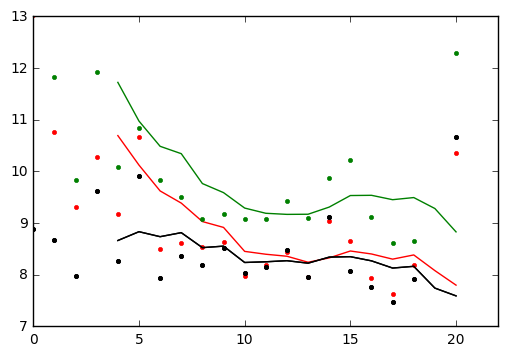

In [5]:
plot_errs(Bayes15,'r',plot_spread=True)
plot_errs(Elo15,'g',plot_spread=True)
plt.xlim([0,22])
plt.ylim([7,13])
plt.show()

##  Logistic regression for probability of beating the spread

In [15]:
from sklearn.linear_model import LogisticRegression
def day_nbr(date):
    y,m,d = [int(x) for x in date.split('-')]
    q={11:0,12:30,1:61,2:92,3:120,4:151}[m]
    if y==2016 & m>=3:
        q+=1
    return q+d

def prepare_model_data(bayes,elo):
    H1=bayes.history[['Date','Away','Home','Spread','Forecast','Actual']]
    H2=elo.history[['Date','Away','Home','Forecast']]
    DF=pd.merge(H1,H2,on=['Date','Away','Home'],how='left')
    DF=DF.rename(columns={'Forecast_x':'BayesModel','Forecast_y':'EloModel'})
    DF['Day']=DF['Date'].apply(day_nbr)
    DF=DF[DF.Spread!=DF.Actual]
    DF['AwayCovered']=DF.apply(lambda row: 1 if row.Actual < row.Spread else 0, axis=1)
    DF=DF[['Day','Spread','EloModel','BayesModel','AwayCovered']]
    DF=DF.dropna(axis=0, how='any')
    return DF

thresh=0.525
def profit(row):
    if row.HomeWinProb>thresh:
        return -1 if row.AwayCovered==1 else 10/11
    if row.HomeWinProb<1-thresh:
        return 10/11 if row.AwayCovered==1 else -1
    return 0

In [16]:
train15=prepare_model_data(Bayes15,Elo15)
train15=train15[train15.Day>50]

print('Running model on 2015-16')
D16=D[(D.Date>'2015-11-01') & (D.Date<'2016-05-01')]
teams=sorted(D16['Away'].append(D16['Home']).unique())
Bayes16=Bayes_NCAAM_Model(teams,home_adv=2.75)
Elo16=Elo_NCAAM_Model(teams,home_adv=0.2,sigma=0.2)
run_models_on_year([Bayes16,Elo16],D16,2016)
train16=prepare_model_data(Bayes16,Elo16)
train16=train16[train16.Day>50]
train=train15.append(train16)

print('Fitting logistic model')
X=train[['Spread','EloModel','BayesModel']].values
Y=train['AwayCovered'].values
REGR=LogisticRegression(fit_intercept=False)
REGR.fit(X,Y)
print('Coefficients: {}, bias: {}'.format(REGR.coef_,REGR.intercept_))

Running model on 2015-16
Fitting logistic model
Coefficients: [[ 0.00311378  0.00739702 -0.00706987]], bias: 0.0


An interpretation of the logistic regression coefficients we just fit is that the spread may be inaccurate when the Bayes and Elo models disagree, and in that case it's better to trust the Bayes model.  That's just a heuristic though, the model outputs an estimated probability of beating the spread in each game.  Now our regressor is fit, let's run our model on the 2016-2017 season and look at some of the predicted probabilities!

In [17]:
print('Running model on 2016-2017')
D17=D[(D.Date>'2016-11-01') & (D.Date<'2017-05-01')]
teams=sorted(D17['Away'].append(D17['Home']).unique())
Bayes17=Bayes_NCAAM_Model(teams,home_adv=2.75)
Elo17=Elo_NCAAM_Model(teams,home_adv=0.2,sigma=0.2)
run_models_on_year([Bayes17,Elo17],D17,2017)

print('Scoring model')
test=prepare_model_data(Bayes17,Elo17)
X_test=test[['Spread','EloModel','BayesModel']].values
test['HomeWinProb']=REGR.predict_proba(X_test)[:,1]
test['GameProfit']=test.apply(profit,axis=1)
test.iloc[-10:]

Running model on 2016-2017
Scoring model


,Day,Spread,EloModel,BayesModel,AwayCovered,HomeWinProb,GameProfit
3989,148,-2.5,-0.880096,-3.723549,1,0.503008,0.0
3990,149,2.0,-1.069255,-4.078065,1,0.506787,0.0
3991,149,7.5,-4.915790,3.272879,0,0.490964,0.0
3992,149,3.0,3.588236,-3.128486,0,0.514496,0.0
3993,150,4.0,5.681130,4.285662,0,0.506045,0.0
3994,151,8.0,1.030887,4.563626,0,0.500068,0.0
3995,151,-3.5,-0.051658,5.070325,0,0.488220,0.0
3996,152,6.5,3.505046,9.136800,1,0.495393,0.0
3997,152,4.5,-0.810409,3.711186,1,0.495445,0.0
3998,154,1.0,2.758254,-1.780081,0,0.509024,0.0


As you can see, in the above 10 games all of the prediced probabilities are within 2.4% of 50%.  When that happens, the model is asserting that it is not profitable to bet at all, and so the "game profit" is necessarily 0.  It's not at all surprising that this is the case for most games-- if it was easy to beat the spread using such limited information, then everyone would be doing it!

So does our model identify any profitable bets at all?  Actually only a few in the 2016-2017 season as the following grah shows:

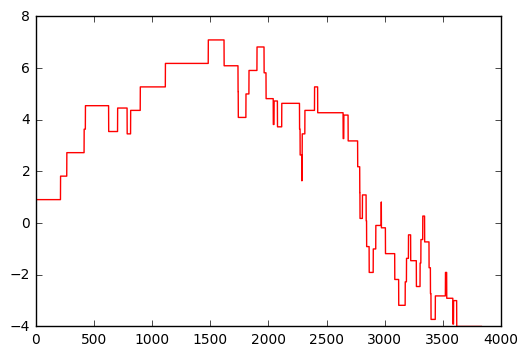

In [19]:
test['NetProfit']=test.GameProfit.cumsum()
plt.plot(range(len(test)),test['NetProfit'],'r-')
plt.show()

In [23]:
from scipy.stats import norm
wins=test.GameProfit.apply(lambda x: 1 if x>0 else 0).sum()
losses=test.GameProfit.apply(lambda x: 1 if x<0 else 0).sum()
n=wins+losses
p=wins/n
z=norm.ppf(0.95)
r=np.sqrt(p*(1-p)/n)*z
str1='Wins={}, losses={}, win rate={:.4f}, 90% confidence interval for true win rate=[{:.4f}, {:.4f}]'
print(str1.format(wins,losses,p,p-r,p+r))

Wins=33, losses=34, win rate=0.4925, 90% confidence interval for true win rate=[0.3921, 0.5930]


From these results we cannot draw any conclusion.  Even if we choose which team to bet on by flipping a coin, we would still expect a win rate of 50%.  To decide whether our betting strategy is effective, we could test a null hypothesis that the win rate is 50% against an alternate hypothesis of a 52.5% winning probability.  Because our 90% confidence interval has a width of about 0.2, we have nowhere near enough data to make an inference.  To distinguish between the two hypotheses we would need to see the model make somewhere in the ballpark of 2500 bets.  Since the model chooses not to bet in most games, this is not feasible with the available data.